In [31]:
# ============================================================
# 1. SETUP AMBIENTE E PARAMETRI COMUNI
# ============================================================
import gymnasium as gym
import numpy as np
import json, os, time
import matplotlib.pyplot as plt

# Crea l'ambiente CliffWalking
env = gym.make("CliffWalking-v1")

# Numero di stati e azioni (tabulari)
n_states = env.observation_space.n    # 48
n_actions = env.action_space.n        # 4

# Parametri comuni di training
EPISODES = 5000
ALPHA = 0.1       # learning rate
GAMMA = 0.99      # discount factor
EPSILON = 0.1     # esplorazione (epsilon-greedy)
MAX_STEPS = 1000  # limite massimo per episodio

# Directory per esportare risultati
os.makedirs("results", exist_ok=True)

print(f"Ambiente: CliffWalking-v0 | Stati: {n_states}, Azioni: {n_actions}")


Ambiente: CliffWalking-v0 | Stati: 48, Azioni: 4


In [32]:
# ============================================================
# 2. FUNZIONI DI SUPPORTO (ε-greedy, valutazione, export)
# ============================================================

def epsilon_greedy(Q, state, epsilon=0.1):
    """Restituisce un'azione epsilon-greedy data la Q-table e lo stato corrente."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))

def evaluate_policy(Q, n_eval=50):
    """Esegue alcuni episodi con policy greedy per stimare la performance media."""
    rewards = []
    for _ in range(n_eval):
        state, _ = env.reset()
        done = False
        total_r = 0
        steps = 0
        while not done and steps < MAX_STEPS:
            action = int(np.argmax(Q[state]))
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_r += reward
            state = next_state
            steps += 1
        rewards.append(total_r)
    return float(np.mean(rewards))


📄 Traiettoria episodio 1000 salvata (13 step, reward -13)
💾 Snapshot salvato: results/snapshots/qtable_qlearning_1000.npz
📄 Traiettoria episodio 2000 salvata (13 step, reward -13)
💾 Snapshot salvato: results/snapshots/qtable_qlearning_2000.npz
📄 Traiettoria episodio 3000 salvata (13 step, reward -13)
💾 Snapshot salvato: results/snapshots/qtable_qlearning_3000.npz
📄 Traiettoria episodio 4000 salvata (13 step, reward -13)
💾 Snapshot salvato: results/snapshots/qtable_qlearning_4000.npz
📄 Traiettoria episodio 5000 salvata (13 step, reward -13)
💾 Snapshot salvato: results/snapshots/qtable_qlearning_5000.npz
✅ Training Q-Learning completato in 2.72s


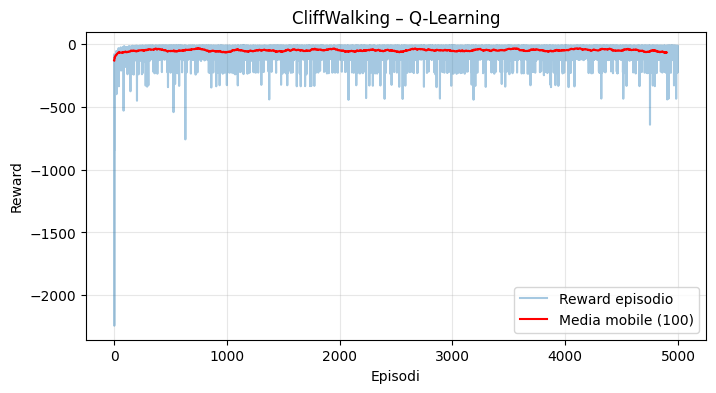

📁 Risultati (ridotti) salvati in: results\qlearning_results.json
Dimensione file: 1.7 KB


In [33]:
# ============================================================
# 3. Q-LEARNING con salvataggio snapshot policy + traiettoria
# ============================================================

import json
algo_name = "qlearning"
os.makedirs("results/snapshots", exist_ok=True)

Q = np.zeros((n_states, n_actions))
rewards_per_episode = []
start_time = time.time()


# ------------------------------------------------------------
# Funzione per salvare la policy (griglia di frecce)
# ------------------------------------------------------------
def export_policy(Q, path):
    """Salva una rappresentazione simbolica della policy (freccine ↑→↓←)."""
    grid = np.full((4, 12), '·', dtype='<U2')
    arrows = {0:'↑', 1:'→', 2:'↓', 3:'←'}
    for s in range(n_states):
        row, col = divmod(s, 12)
        a = np.argmax(Q[s])
        grid[row, col] = arrows[a]
    np.savez(path, grid=grid)


# ------------------------------------------------------------
# Funzione per salvare una traiettoria greedy ogni N episodi
# ------------------------------------------------------------
def record_trajectory(env, Q, algo_name, episode, folder="results/snapshots", max_steps=200):
    """Esegue un episodio greedy con la Q-table corrente e salva la traiettoria in JSON."""
    trajectory = []
    state, _ = env.reset(seed=42)
    done = False
    total_reward = 0

    for t in range(max_steps):
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        trajectory.append({
            "step": t,
            "state": int(state),
            "action": int(action),
            "reward": float(reward),
            "next_state": int(next_state)
        })
        total_reward += reward
        state = next_state
        if done:
            break

    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"traj_{algo_name}_{episode}.json")
    with open(path, "w") as f:
        json.dump(trajectory, f, indent=2)

    print(f"📄 Traiettoria episodio {episode} salvata ({len(trajectory)} step, reward {total_reward})")


# ------------------------------------------------------------
# Training Q-Learning
# ------------------------------------------------------------
for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False

    for step in range(MAX_STEPS):
        # Azione epsilon-greedy
        action = epsilon_greedy(Q, state, EPSILON)

        # Interazione con l'ambiente
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Aggiornamento Q-learning
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + GAMMA * Q[next_state, best_next_action]
        td_error = td_target - Q[state, action]
        Q[state, action] += ALPHA * td_error

        total_reward += reward
        state = next_state
        if done:
            break

    rewards_per_episode.append(total_reward)

    # 🔹 Snapshot + traiettoria ogni 1000 episodi
    if (episode + 1) % 1000 == 0:
        path = f"results/snapshots/qtable_{algo_name}_{episode+1}.npz"
        np.savez(path, Q=Q)
        export_policy(Q, path.replace("qtable_", "policy_"))
        record_trajectory(env, Q, algo_name, episode+1)  # 🔹 nuova riga
        print(f"💾 Snapshot salvato: {path}")

elapsed = time.time() - start_time
print(f"✅ Training Q-Learning completato in {elapsed:.2f}s")


# ------------------------------------------------------------
# Analisi e salvataggio risultati
# ------------------------------------------------------------
window = 100
moving_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards_per_episode, alpha=0.4, label='Reward episodio')
plt.plot(moving_avg, color='red', label=f'Media mobile ({window})')
plt.xlabel("Episodi")
plt.ylabel("Reward")
plt.title("CliffWalking – Q-Learning")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

mean_reward_eval = evaluate_policy(Q)

from datetime import datetime
SAMPLE_INTERVAL = 50
sampled_rewards = rewards_per_episode[::SAMPLE_INTERVAL]

results = {
    "algorithm": "Q-Learning",
    "environment": "CliffWalking-v0",
    "episodes": EPISODES,
    "alpha": ALPHA,
    "gamma": GAMMA,
    "epsilon": EPSILON,
    "mean_eval_reward": mean_reward_eval,
    "mean_last100": float(np.mean(rewards_per_episode[-100:])),
    "elapsed_sec": round(elapsed, 2),
    "sampled_rewards": {
        "interval": SAMPLE_INTERVAL,
        "values": [round(float(r), 2) for r in sampled_rewards]
    },
    "timestamp": datetime.now().isoformat(timespec='seconds')
}

path = os.path.join("results", "qlearning_results.json")
with open(path, "w") as f:
    json.dump(results, f, indent=2)

print(f"📁 Risultati (ridotti) salvati in: {path}")
print(f"Dimensione file: {os.path.getsize(path)/1024:.1f} KB")


📄 Traiettoria episodio 1000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_1000.npz
📄 Traiettoria episodio 2000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_2000.npz
📄 Traiettoria episodio 3000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_3000.npz
📄 Traiettoria episodio 4000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_4000.npz
📄 Traiettoria episodio 5000 salvata (17 step, reward -17)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_5000.npz
✅ Training SARSA completato in 6.11s


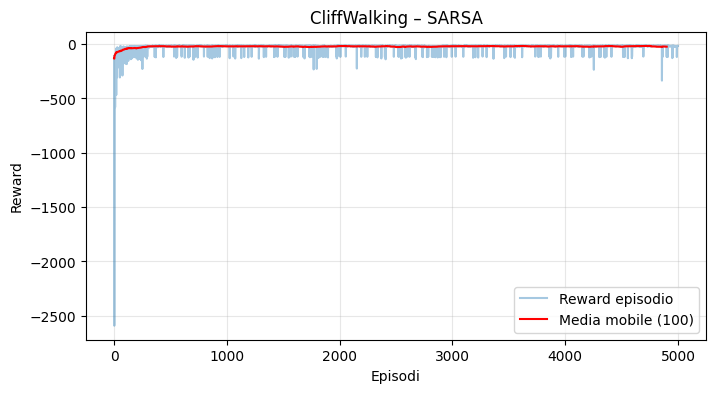

📁 Risultati (ridotti) salvati in: results\sarsa_results.json
Dimensione file: 1.7 KB


In [34]:
# ============================================================
# 4. SARSA (on-policy) con salvataggio snapshot + traiettoria
# ============================================================

import json
algo_name = "sarsa"
os.makedirs("results/snapshots", exist_ok=True)

Q = np.zeros((n_states, n_actions))
rewards_per_episode = []
start_time = time.time()


# ------------------------------------------------------------
# Funzione per salvare la policy (griglia frecce)
# ------------------------------------------------------------
def export_policy(Q, path):
    """Salva una rappresentazione simbolica della policy (freccine ↑→↓←)."""
    grid = np.full((4, 12), '·', dtype='<U2')
    arrows = {0:'↑', 1:'→', 2:'↓', 3:'←'}
    for s in range(n_states):
        row, col = divmod(s, 12)
        a = np.argmax(Q[s])
        grid[row, col] = arrows[a]
    np.savez(path, grid=grid)


# ------------------------------------------------------------
# Funzione per salvare la traiettoria greedy ogni N episodi
# ------------------------------------------------------------
def record_trajectory(env, Q, algo_name, episode, folder="results/snapshots", max_steps=200):
    """
    Esegue un episodio greedy con la Q-table corrente e salva la traiettoria in JSON.
    """
    trajectory = []
    state, _ = env.reset(seed=42)
    done = False
    total_reward = 0

    for t in range(max_steps):
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        trajectory.append({
            "step": t,
            "state": int(state),
            "action": int(action),
            "reward": float(reward),
            "next_state": int(next_state)
        })
        total_reward += reward
        state = next_state
        if done:
            break

    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"traj_{algo_name}_{episode}.json")
    with open(path, "w") as f:
        json.dump(trajectory, f, indent=2)

    print(f"📄 Traiettoria episodio {episode} salvata ({len(trajectory)} step, reward {total_reward})")


# ------------------------------------------------------------
# Training SARSA (on-policy)
# ------------------------------------------------------------
for episode in range(EPISODES):
    state, _ = env.reset()
    action = epsilon_greedy(Q, state, EPSILON)
    total_reward = 0
    done = False

    for step in range(MAX_STEPS):
        # Esegui l'azione scelta
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Scegli la prossima azione secondo la policy corrente (on-policy)
        next_action = epsilon_greedy(Q, next_state, EPSILON)

        # Aggiornamento SARSA (usa l'azione realmente eseguita)
        td_target = reward + GAMMA * Q[next_state, next_action]
        td_error = td_target - Q[state, action]
        Q[state, action] += ALPHA * td_error

        total_reward += reward
        state, action = next_state, next_action

        if done:
            break

    rewards_per_episode.append(total_reward)

    # 🔹 Snapshot + traiettoria ogni 1000 episodi
    if (episode + 1) % 1000 == 0:
        path = f"results/snapshots/qtable_{algo_name}_{episode+1}.npz"
        np.savez(path, Q=Q)
        export_policy(Q, path.replace("qtable_", "policy_"))
        record_trajectory(env, Q, algo_name, episode+1)  # 🔹 nuova riga
        print(f"💾 Snapshot salvato: {path}")


elapsed = time.time() - start_time
print(f"✅ Training SARSA completato in {elapsed:.2f}s")


# ------------------------------------------------------------
# Analisi e salvataggio risultati
# ------------------------------------------------------------
window = 100
moving_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards_per_episode, alpha=0.4, label='Reward episodio')
plt.plot(moving_avg, color='red', label=f'Media mobile ({window})')
plt.xlabel("Episodi")
plt.ylabel("Reward")
plt.title("CliffWalking – SARSA")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

mean_reward_eval = evaluate_policy(Q)

from datetime import datetime
SAMPLE_INTERVAL = 50
sampled_rewards = rewards_per_episode[::SAMPLE_INTERVAL]

results = {
    "algorithm": "SARSA",
    "environment": "CliffWalking-v0",
    "episodes": EPISODES,
    "alpha": ALPHA,
    "gamma": GAMMA,
    "epsilon": EPSILON,
    "mean_eval_reward": mean_reward_eval,
    "mean_last100": float(np.mean(rewards_per_episode[-100:])),
    "elapsed_sec": round(elapsed, 2),
    "sampled_rewards": {
        "interval": SAMPLE_INTERVAL,
        "values": [round(float(r), 2) for r in sampled_rewards]
    },
    "timestamp": datetime.now().isoformat(timespec='seconds')
}

path = os.path.join("results", "sarsa_results.json")
with open(path, "w") as f:
    json.dump(results, f, indent=2)

print(f"📁 Risultati (ridotti) salvati in: {path}")
print(f"Dimensione file: {os.path.getsize(path)/1024:.1f} KB")


📄 Traiettoria episodio 1000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_expected_sarsa_1000.npz
📄 Traiettoria episodio 2000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_expected_sarsa_2000.npz
📄 Traiettoria episodio 3000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_expected_sarsa_3000.npz
📄 Traiettoria episodio 4000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_expected_sarsa_4000.npz
📄 Traiettoria episodio 5000 salvata (15 step, reward -15)
💾 Snapshot salvato: results/snapshots/qtable_expected_sarsa_5000.npz
✅ Training Expected SARSA completato in 8.82s


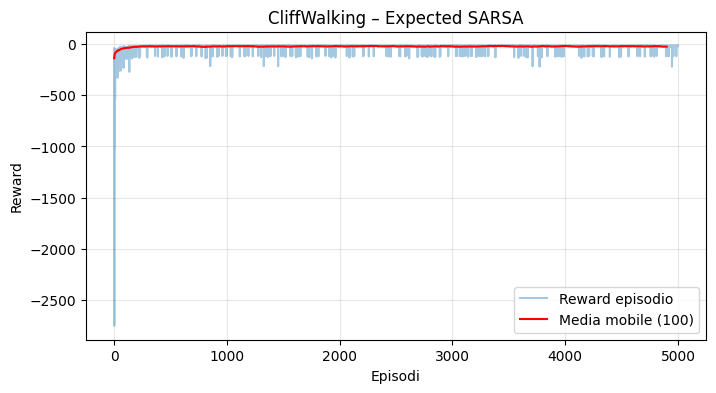

📁 Risultati (ridotti) salvati in: results\expected_sarsa_results.json
Dimensione file: 1.7 KB


In [35]:
# ============================================================
# 5. EXPECTED SARSA – con salvataggio snapshot + traiettoria
# ============================================================

import json
algo_name = "expected_sarsa"
os.makedirs("results/snapshots", exist_ok=True)

Q = np.zeros((n_states, n_actions))
rewards_per_episode = []
start_time = time.time()


# ------------------------------------------------------------
# Funzione per salvare la policy (griglia frecce)
# ------------------------------------------------------------
def export_policy(Q, path):
    """Salva una rappresentazione simbolica della policy (freccine ↑→↓←)."""
    grid = np.full((4, 12), '·', dtype='<U2')
    arrows = {0:'↑', 1:'→', 2:'↓', 3:'←'}
    for s in range(n_states):
        row, col = divmod(s, 12)
        a = np.argmax(Q[s])
        grid[row, col] = arrows[a]
    np.savez(path, grid=grid)


# ------------------------------------------------------------
# Expected SARSA – valore atteso sotto policy ε-greedy
# ------------------------------------------------------------
def expected_value(Q, state, epsilon=0.1):
    """Restituisce l'attesa del valore Q(s,·) sotto la policy ε-greedy."""
    greedy_a = np.argmax(Q[state])
    policy = np.ones(n_actions) * (epsilon / n_actions)
    policy[greedy_a] += 1 - epsilon
    return np.dot(policy, Q[state])


# ------------------------------------------------------------
# Funzione per salvare la traiettoria greedy ogni N episodi
# ------------------------------------------------------------
def record_trajectory(env, Q, algo_name, episode, folder="results/snapshots", max_steps=200):
    """Esegue un episodio greedy con la Q-table corrente e salva la traiettoria in JSON."""
    trajectory = []
    state, _ = env.reset(seed=42)
    done = False
    total_reward = 0

    for t in range(max_steps):
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        trajectory.append({
            "step": t,
            "state": int(state),
            "action": int(action),
            "reward": float(reward),
            "next_state": int(next_state)
        })
        total_reward += reward
        state = next_state
        if done:
            break

    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"traj_{algo_name}_{episode}.json")
    with open(path, "w") as f:
        json.dump(trajectory, f, indent=2)

    print(f"📄 Traiettoria episodio {episode} salvata ({len(trajectory)} step, reward {total_reward})")


# ------------------------------------------------------------
# Training EXPECTED SARSA
# ------------------------------------------------------------
for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False

    for step in range(MAX_STEPS):
        # Azione epsilon-greedy
        action = epsilon_greedy(Q, state, EPSILON)

        # Interazione con l'ambiente
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Aggiornamento Expected SARSA (usa l'attesa della Q futura)
        exp_Q = expected_value(Q, next_state, EPSILON)
        td_target = reward + GAMMA * exp_Q
        td_error = td_target - Q[state, action]
        Q[state, action] += ALPHA * td_error

        total_reward += reward
        state = next_state
        if done:
            break

    rewards_per_episode.append(total_reward)

    # 🔹 Snapshot + traiettoria ogni 1000 episodi
    if (episode + 1) % 1000 == 0:
        path = f"results/snapshots/qtable_{algo_name}_{episode+1}.npz"
        np.savez(path, Q=Q)
        export_policy(Q, path.replace("qtable_", "policy_"))
        record_trajectory(env, Q, algo_name, episode+1)  # 🔹 nuova riga
        print(f"💾 Snapshot salvato: {path}")


elapsed = time.time() - start_time
print(f"✅ Training Expected SARSA completato in {elapsed:.2f}s")


# ------------------------------------------------------------
# Analisi e salvataggio risultati
# ------------------------------------------------------------
window = 100
moving_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards_per_episode, alpha=0.4, label='Reward episodio')
plt.plot(moving_avg, color='red', label=f'Media mobile ({window})')
plt.xlabel("Episodi")
plt.ylabel("Reward")
plt.title("CliffWalking – Expected SARSA")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

mean_reward_eval = evaluate_policy(Q)

from datetime import datetime
SAMPLE_INTERVAL = 50
sampled_rewards = rewards_per_episode[::SAMPLE_INTERVAL]

results = {
    "algorithm": "Expected SARSA",
    "environment": "CliffWalking-v0",
    "episodes": EPISODES,
    "alpha": ALPHA,
    "gamma": GAMMA,
    "epsilon": EPSILON,
    "mean_eval_reward": mean_reward_eval,
    "mean_last100": float(np.mean(rewards_per_episode[-100:])),
    "elapsed_sec": round(elapsed, 2),
    "sampled_rewards": {
        "interval": SAMPLE_INTERVAL,
        "values": [round(float(r), 2) for r in sampled_rewards]
    },
    "timestamp": datetime.now().isoformat(timespec='seconds')
}

path = os.path.join("results", "expected_sarsa_results.json")
with open(path, "w") as f:
    json.dump(results, f, indent=2)

print(f"📁 Risultati (ridotti) salvati in: {path}")
print(f"Dimensione file: {os.path.getsize(path)/1024:.1f} KB")


📄 Traiettoria episodio 1000 salvata (19 step, reward -19)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_lambda_1000.npz
📄 Traiettoria episodio 2000 salvata (19 step, reward -19)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_lambda_2000.npz
📄 Traiettoria episodio 3000 salvata (17 step, reward -17)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_lambda_3000.npz
📄 Traiettoria episodio 4000 salvata (17 step, reward -17)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_lambda_4000.npz
📄 Traiettoria episodio 5000 salvata (17 step, reward -17)
💾 Snapshot salvato: results/snapshots/qtable_sarsa_lambda_5000.npz
✅ Training SARSA(λ) completato in 6.17s


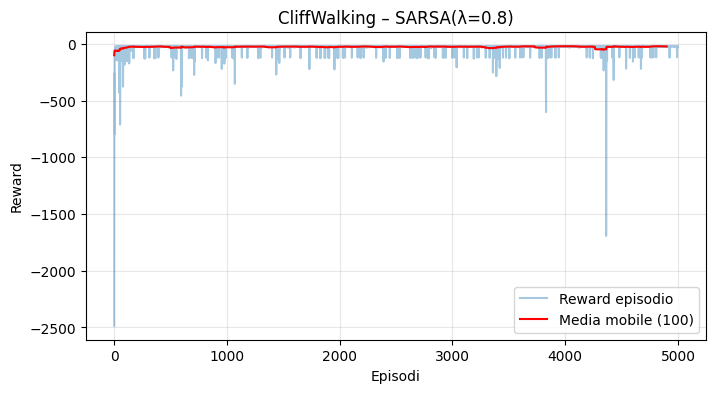

📁 Risultati (ridotti) salvati in: results\sarsa_lambda_results.json
Dimensione file: 1.7 KB


In [36]:
# ============================================================
# 6. SARSA(λ) con eligibility traces (replacing) + traiettoria
# ============================================================

import json
algo_name = "sarsa_lambda"
os.makedirs("results/snapshots", exist_ok=True)

# Iperparametri
LAMBDA = 0.8

Q = np.zeros((n_states, n_actions))
E = np.zeros_like(Q)  # eligibility traces
rewards_per_episode = []
start_time = time.time()


# ------------------------------------------------------------
# Funzione per salvare la policy (freccine)
# ------------------------------------------------------------
def export_policy(Q, path):
    """Salva una rappresentazione simbolica della policy (freccine ↑→↓←)."""
    grid = np.full((4, 12), '·', dtype='<U2')
    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    for s in range(n_states):
        row, col = divmod(s, 12)
        a = np.argmax(Q[s])
        grid[row, col] = arrows[a]
    np.savez(path, grid=grid)


# ------------------------------------------------------------
# Funzione per salvare traiettoria greedy
# ------------------------------------------------------------
def record_trajectory(env, Q, algo_name, episode, folder="results/snapshots", max_steps=200):
    """Esegue un episodio greedy con la Q-table corrente e salva la traiettoria in JSON."""
    trajectory = []
    state, _ = env.reset(seed=42)
    done = False
    total_reward = 0

    for t in range(max_steps):
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        trajectory.append({
            "step": t,
            "state": int(state),
            "action": int(action),
            "reward": float(reward),
            "next_state": int(next_state)
        })
        total_reward += reward
        state = next_state
        if done:
            break

    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, f"traj_{algo_name}_{episode}.json")
    with open(path, "w") as f:
        json.dump(trajectory, f, indent=2)

    print(f"📄 Traiettoria episodio {episode} salvata ({len(trajectory)} step, reward {total_reward})")


# ------------------------------------------------------------
# Training SARSA(λ)
# ------------------------------------------------------------
for episode in range(EPISODES):
    state, _ = env.reset()
    action = epsilon_greedy(Q, state, EPSILON)
    total_reward = 0
    done = False

    # Azzera le tracce
    E.fill(0.0)

    for step in range(MAX_STEPS):
        # Passo di interazione
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Prossima azione on-policy
        next_action = epsilon_greedy(Q, next_state, EPSILON)

        # TD-error
        td_target = reward + GAMMA * Q[next_state, next_action]
        td_error = td_target - Q[state, action]

        # --- Replacing traces ---
        E *= (GAMMA * LAMBDA)
        E[state, action] = 1.0  # reset trace for current (s,a)

        # Aggiornamento simultaneo
        Q += ALPHA * td_error * E

        total_reward += reward
        state, action = next_state, next_action

        if done:
            break

    rewards_per_episode.append(total_reward)

    # 🔹 Snapshot + traiettoria ogni 1000 episodi
    if (episode + 1) % 1000 == 0:
        path = f"results/snapshots/qtable_{algo_name}_{episode+1}.npz"
        np.savez(path, Q=Q, lambda_=LAMBDA)
        export_policy(Q, path.replace("qtable_", "policy_"))
        record_trajectory(env, Q, algo_name, episode+1)  # 🔹 aggiunto
        print(f"💾 Snapshot salvato: {path}")


elapsed = time.time() - start_time
print(f"✅ Training SARSA(λ) completato in {elapsed:.2f}s")


# ------------------------------------------------------------
# Analisi e salvataggio risultati
# ------------------------------------------------------------
window = 100
moving_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(rewards_per_episode, alpha=0.4, label='Reward episodio')
plt.plot(moving_avg, color='red', label=f'Media mobile ({window})')
plt.xlabel("Episodi")
plt.ylabel("Reward")
plt.title(f"CliffWalking – SARSA(λ={LAMBDA})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

mean_reward_eval = evaluate_policy(Q)

from datetime import datetime
SAMPLE_INTERVAL = 50
sampled_rewards = rewards_per_episode[::SAMPLE_INTERVAL]

results = {
    "algorithm": "SARSA(λ)",
    "environment": "CliffWalking-v0",
    "episodes": EPISODES,
    "alpha": ALPHA,
    "gamma": GAMMA,
    "epsilon": EPSILON,
    "lambda": LAMBDA,
    "mean_eval_reward": mean_reward_eval,
    "mean_last100": float(np.mean(rewards_per_episode[-100:])),
    "elapsed_sec": round(elapsed, 2),
    "sampled_rewards": {
        "interval": SAMPLE_INTERVAL,
        "values": [round(float(r), 2) for r in sampled_rewards]
    },
    "timestamp": datetime.now().isoformat(timespec='seconds')
}

path = os.path.join("results", "sarsa_lambda_results.json")
with open(path, "w") as f:
    json.dump(results, f, indent=2)

print(f"📁 Risultati (ridotti) salvati in: {path}")
print(f"Dimensione file: {os.path.getsize(path)/1024:.1f} KB")


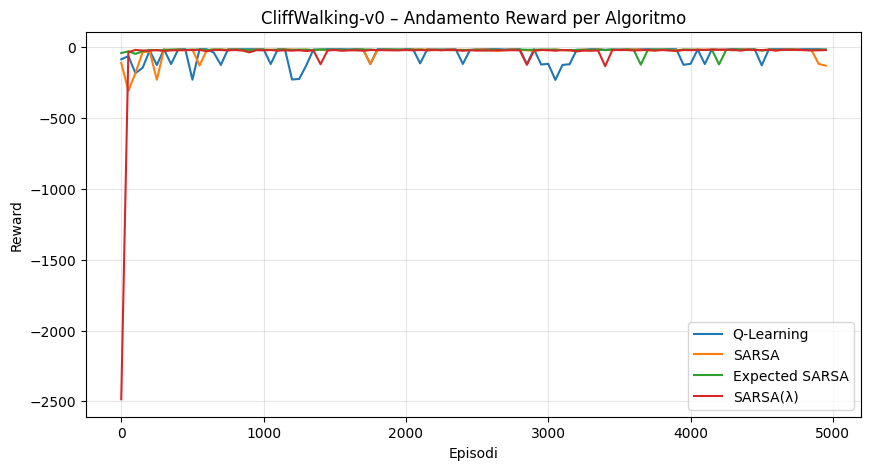

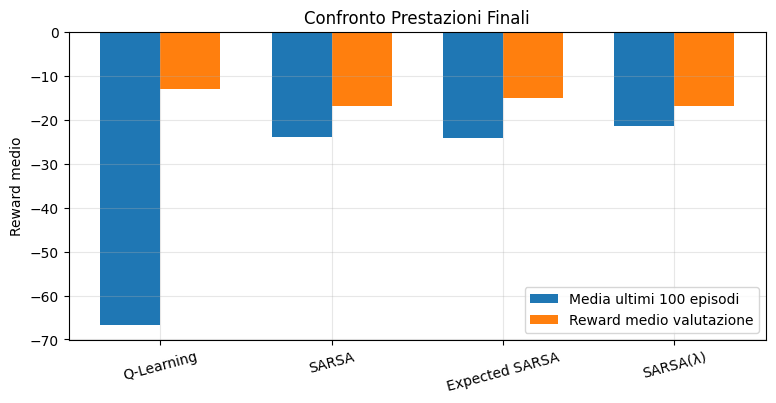

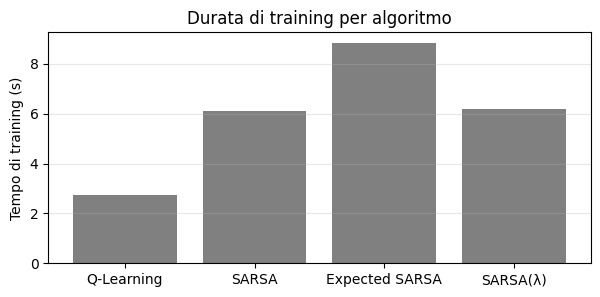

📁 Riassunto comparativo salvato in: results/comparison_summary.json


In [37]:
# ============================================================
# 7. CONFRONTO COMPARATIVO: Q-Learning vs SARSA vs Expected SARSA vs SARSA(λ)
# ============================================================

import json
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------------------------------------------------
# Percorsi dei risultati
# ------------------------------------------------------------
result_files = {
    "Q-Learning": "results/qlearning_results.json",
    "SARSA": "results/sarsa_results.json",
    "Expected SARSA": "results/expected_sarsa_results.json",
    "SARSA(λ)": "results/sarsa_lambda_results.json"
}

# ------------------------------------------------------------
# Caricamento dei risultati
# ------------------------------------------------------------
all_results = {}
for name, path in result_files.items():
    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
            all_results[name] = data
    else:
        print(f"⚠️ Attenzione: file mancante → {path}")

# ------------------------------------------------------------
# Plot 1 – Curve di reward campionate
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
for name, data in all_results.items():
    rewards = data["sampled_rewards"]["values"]
    interval = data["sampled_rewards"]["interval"]
    episodes = np.arange(0, len(rewards)*interval, interval)
    plt.plot(episodes, rewards, label=name)
plt.xlabel("Episodi")
plt.ylabel("Reward")
plt.title("CliffWalking-v0 – Andamento Reward per Algoritmo")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# Plot 2 – Media ultimi 100 episodi e reward medio di valutazione
# ------------------------------------------------------------
labels, mean_last100, mean_eval, elapsed = [], [], [], []

for name, data in all_results.items():
    labels.append(name)
    mean_last100.append(data.get("mean_last100", 0))
    mean_eval.append(data.get("mean_eval_reward", 0))
    elapsed.append(data.get("elapsed_sec", 0))

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(9,4))
ax1.bar(x - width/2, mean_last100, width, label='Media ultimi 100 episodi')
ax1.bar(x + width/2, mean_eval, width, label='Reward medio valutazione')
ax1.set_ylabel("Reward medio")
ax1.set_title("Confronto Prestazioni Finali")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=15)
ax1.legend()
ax1.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# Plot 3 – Tempi di training
# ------------------------------------------------------------
plt.figure(figsize=(7,3))
plt.bar(labels, elapsed, color='gray')
plt.ylabel("Tempo di training (s)")
plt.title("Durata di training per algoritmo")
plt.grid(axis='y', alpha=0.3)
plt.show()

# ------------------------------------------------------------
# Rilevamento snapshot disponibili per ogni algoritmo
# ------------------------------------------------------------
snapshots_dir = "results/snapshots"
available_snapshots = {}

if os.path.exists(snapshots_dir):
    for fname in os.listdir(snapshots_dir):
        # Esempio: policy_sarsa_lambda_3000.npz
        if fname.startswith("policy_") and fname.endswith(".npz"):
            parts = fname.replace(".npz", "").split("_")

            # parts: ["policy", "sarsa", "lambda", "3000"]
            algo = "_".join(parts[1:-1])  # unisci tutto ciò che è tra "policy" e episodio
            ep = int(parts[-1])
            available_snapshots.setdefault(algo, []).append(ep)

# Ordina le liste per episodio crescente
for algo in available_snapshots:
    available_snapshots[algo].sort()

# ------------------------------------------------------------
# Esportazione riassunto comparativo per Flask
# ------------------------------------------------------------
summary = {
    "algorithms": labels,
    "mean_last100": mean_last100,
    "mean_eval": mean_eval,
    "elapsed_sec": elapsed,
    "available_snapshots": available_snapshots
}

summary_path = "results/comparison_summary.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"📁 Riassunto comparativo salvato in: {summary_path}")


In [38]:
# ============================================================
# 🔁 POST-PROCESSING: Spostamento traiettorie JSON
# ============================================================

import os, shutil

# Percorsi
SRC_DIR = "results/snapshots"
DST_DIR = os.path.join("experiments", "cliffwalking", "data")

# Crea la cartella di destinazione se non esiste
os.makedirs(DST_DIR, exist_ok=True)

# Conta quanti file vengono spostati
count = 0

if not os.path.exists(SRC_DIR):
    print(f"❌ Cartella sorgente non trovata: {SRC_DIR}")
else:
    for fname in os.listdir(SRC_DIR):
        if fname.startswith("traj_") and fname.endswith(".json"):
            src = os.path.join(SRC_DIR, fname)
            dst = os.path.join(DST_DIR, fname)
            shutil.move(src, dst)
            count += 1
            print(f"📦 Spostato: {fname}")

if count > 0:
    print(f"\n✅ {count} file di traiettoria spostati in '{DST_DIR}'")
else:
    print("\n⚠️ Nessun file di traiettoria trovato da spostare.")


📦 Spostato: traj_expected_sarsa_1000.json
📦 Spostato: traj_expected_sarsa_2000.json
📦 Spostato: traj_expected_sarsa_3000.json
📦 Spostato: traj_expected_sarsa_4000.json
📦 Spostato: traj_expected_sarsa_5000.json
📦 Spostato: traj_qlearning_1000.json
📦 Spostato: traj_qlearning_2000.json
📦 Spostato: traj_qlearning_3000.json
📦 Spostato: traj_qlearning_4000.json
📦 Spostato: traj_qlearning_5000.json
📦 Spostato: traj_sarsa_1000.json
📦 Spostato: traj_sarsa_2000.json
📦 Spostato: traj_sarsa_3000.json
📦 Spostato: traj_sarsa_4000.json
📦 Spostato: traj_sarsa_5000.json
📦 Spostato: traj_sarsa_lambda_1000.json
📦 Spostato: traj_sarsa_lambda_2000.json
📦 Spostato: traj_sarsa_lambda_3000.json
📦 Spostato: traj_sarsa_lambda_4000.json
📦 Spostato: traj_sarsa_lambda_5000.json

✅ 20 file di traiettoria spostati in 'experiments\cliffwalking\data'
